## Paquid Data Test

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from lifelines import ExponentialFitter
from sklearn.neighbors import KernelDensity
from torch import nn

import jmstate
from jmstate import MultiStateJointModel
from jmstate.typedefs import *
from jmstate.utils import *

In [2]:
paquid = pd.read_csv("data/paquid.csv")
print(paquid.head())

   ID  MMSE  BVRT   IST  HIER  CESD        age     agedem  dem  age_init  CEP  \
0   1  26.0  10.0  37.0   2.0  11.0  68.506300  68.506300    0   67.4167    1   
1   2  26.0  13.0  25.0   1.0  10.0  66.995400  85.616701    1   65.9167    1   
2   2  28.0  13.0  28.0   1.0  15.0  69.095300  85.616701    1   65.9167    1   
3   2  25.0  12.0  23.0   1.0  18.0  73.807200  85.616701    1   65.9167    1   
4   2  24.0  13.0  16.0   3.0  22.0  84.142368  85.616701    1   65.9167    1   

   male  
0     1  
1     0  
2     0  
3     0  
4     0  


In [3]:
def get_trajectory(id, hier_levels=range(4)):
    s = (
        paquid.loc[paquid["ID"] == id]
        .groupby("HIER")["age"]
        .min()
        .reindex(hier_levels)
        .dropna()
    )
    if len(s) <= 1:
        return [(float(a), int(k)) for k, a in s.items()]
    keep = s >= s.cummax()
    s = s[keep]
    return [(float(a), int(k)) for k, a in s.items()]


def get_last_visit_age(id):
    return paquid[paquid["ID"] == id]["age"].max()


def get_t(id):
    return torch.tensor(paquid[paquid["ID"] == id]["age"].values)


def get_X(id):
    return torch.tensor(
        paquid.loc[paquid["ID"] == id, ["CEP", "male"]].iloc[0].to_numpy()
    )


def get_Y(id):
    return torch.tensor(paquid[paquid["ID"] == id]["MMSE"].values)

In [4]:
ids = range(1, 501)

trajectories0 = [get_trajectory(id) for id in ids]
c0 = torch.tensor([get_last_visit_age(id) for id in ids]).view(-1, 1)
t0 = torch.nn.utils.rnn.pad_sequence(
    [get_t(id) for id in ids], batch_first=True, padding_value=torch.nan
)
y0 = torch.nn.utils.rnn.pad_sequence(
    [get_Y(id) for id in ids], batch_first=True, padding_value=torch.nan
)[..., None]
x = torch.cat([get_X(id).view(1, -1) for id in ids], dim=0)

In [5]:
t_min, t_max = torch.nanquantile(t0, 0).item(), torch.nanquantile(t0, 1).item()
y_min, y_max = torch.nanquantile(y0, 0).item(), torch.nanquantile(y0, 1).item()


def normalize_t(t):
    return (2.0 * t - (t_max + t_min)) / (t_max - t_min)


def normalize_y(y):
    return (2.0 * y - (y_max + y_min)) / (y_max - y_min)

In [6]:
y = normalize_y(y0)
trajectories = [
    [
        (
            normalize_t(m),
            s,
        )
        for (m, s) in trajectory
    ]
    for trajectory in trajectories0
]
t = normalize_t(t0)
c = normalize_t(c0)

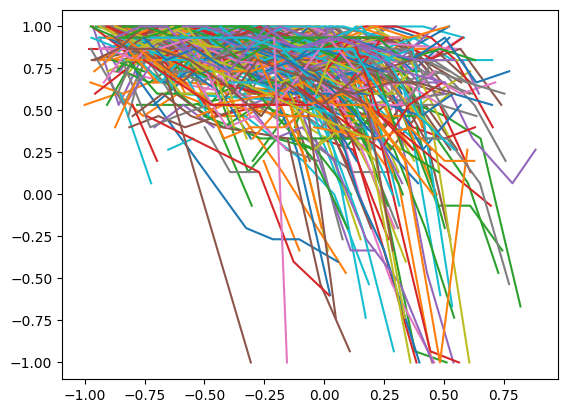

In [7]:
plt.plot(t.T, y[:, :, 0].T)
plt.show()

In [8]:
buckets = build_buckets(trajectories)

In [9]:
surv_params = {}
for key, value in buckets.items():
    t0, t1 = value.t0, value.t1
    exp_fit = ExponentialFitter().fit(t1 - t0)
    surv_params[key] = exp_fit.lambda_

In [10]:
net = nn.Sequential(
    nn.Linear(5, 3),
    nn.Tanh(),
    nn.Linear(3, 3),
    nn.Tanh(),
    nn.Linear(3, 1),
    nn.Tanh(),
)

reg = jmstate.functions.Net(net)

surv = {key: (jmstate.functions.exponential(surv_params[key]), reg.derivatives((0, 1))) for key in buckets}

init_alphas = {key: torch.zeros(2) for key in buckets}
init_betas = {key: torch.zeros(2) for key in buckets}

init_params = ModelParams(
    None,
    repr_from_cov(torch.eye(4), method="diag"),
    repr_from_cov(torch.eye(1), method="ball"),
    init_alphas,
    init_betas,
    extra=list(reg.parameters()),
)

model_design = ModelDesign(
    jmstate.functions.identity,
    reg,
    surv,
)

In [11]:
data = ModelData(x, t, y, trajectories, c)

Running joint model: 100%|██████████| 2000/2000 [04:24<00:00,  7.55it/s]


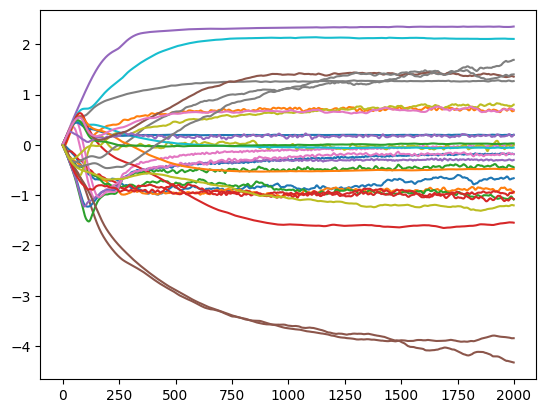

In [12]:
model = MultiStateJointModel(model_design, init_params)
metrics = model.do(
    data,
    jobs=[
        jmstate.jobs.RandomFit(lr=1e-2),
        jmstate.jobs.LogParamsHistory(),
    ],
    max_iterations=2000,
)

plt.plot(torch.cat([p.as_flat_tensor[None] for p in metrics], dim=0))
plt.show()

In [13]:
print(model.params_)

ModelParams(gamma=None, Q_repr=MatRepr(flat=tensor([-0.6634, -0.9502, -1.0857, -1.0771]), dim=4, method='diag'), R_repr=MatRepr(flat=tensor([2.3522]), dim=1, method='ball'), alphas={(1, 3): tensor([-4.3272, -0.0110]), (0, 1): tensor([1.2678, 0.0023]), (1, 2): tensor([ 2.1057, -0.1853]), (0, 2): tensor([ 0.6776, -0.4462]), (2, 3): tensor([-1.5481, -0.2997]), (0, 3): tensor([-3.8443, -0.1865])}, betas={(1, 3): tensor([1.6896, 0.7988]), (0, 1): tensor([-0.0553,  0.1990]), (1, 2): tensor([-0.4810,  0.0273]), (0, 2): tensor([-0.9319,  0.1962]), (2, 3): tensor([1.3552, 0.6977]), (0, 3): tensor([ 1.4008, -1.2035])})


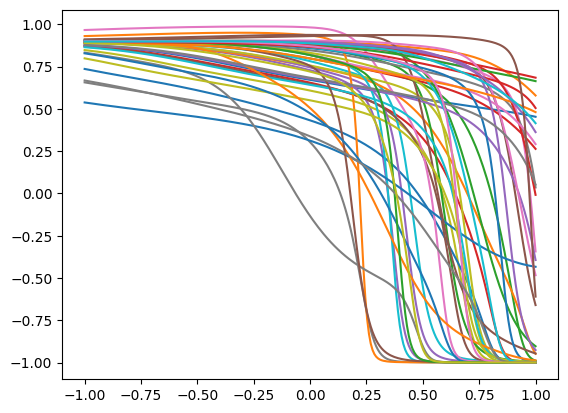

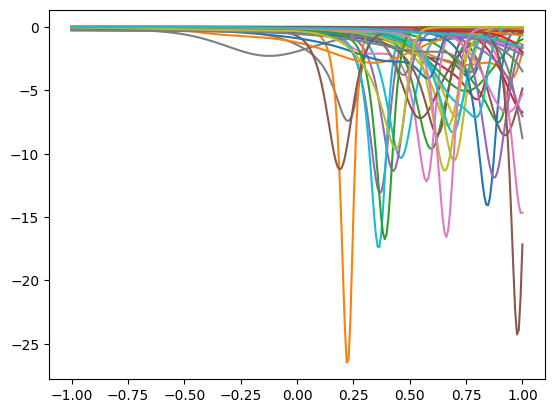

In [26]:
n_test = 50
t_test = torch.linspace(t.nanquantile(0), t.nanquantile(1), 250)

Q_dist = torch.distributions.MultivariateNormal(
    torch.zeros(4), model.params_.get_cov("Q")
)
R_dist = torch.distributions.MultivariateNormal(
    torch.zeros(1), model.params_.get_cov("R")
)

x_test = x[:n_test]
b_test = Q_dist.sample((n_test,))
psi_test = model_design.individual_effects_fn(model.params_.gamma, x_test, b_test)
trajectories_init_test = [[trajectories[i][0]] for i in range(n_test)]
y_test = model_design.surv[(0, 1)][1](t_test, psi_test)
plt.plot(t_test, y_test[:, :, 0].T)
plt.show()
plt.plot(t_test, y_test[:, :, 1].T)
plt.show()

In [27]:
sample_data_test = SampleData(x_test, trajectories_init_test, psi_test)
trajectories_test = model.sample_trajectories(
    sample_data_test, torch.full((len(trajectories_init_test), 1), 1.0)
)

In [28]:
print(trajectories)
print(trajectories_test)

[[(-0.8757215796636038, 2)], [(-0.9599394955616394, 1), (-0.004163514870109049, 3)], [(-0.6479614193942509, 1)], [(-0.5720933901872765, 1)], [(-0.8817359506513582, 0), (-0.37294366070975404, 1), (0.04436596805110103, 2)], [(-0.6146064648152684, 0), (0.055037162594882144, 2)], [(0.07589795000588542, 2)], [(-0.5567369563862914, 1), (-0.03924437932268553, 2)], [(-0.19183353033129585, 1), (-0.0750911893048564, 2)], [(-0.17596986042290877, 1), (0.08193461708627281, 2)], [(-0.030086526325126157, 2)], [(-0.5194244453649498, 1), (-0.4060376662797788, 2)], [(0.0066128421488079086, 1), (0.11954255133500208, 2), (0.3792864564864078, 3)], [(-0.30111225434883465, 2)], [(-0.7008867692818578, 1)], [(0.0031067815822671775, 2)], [(-0.801235908199876, 0)], [(-0.7739845089791798, 0), (-0.6628886534120505, 1)], [(0.13598034562868844, 2)], [(-0.2802431116443371, 2)], [(-0.3370674239543441, 0)], [(-0.8724496280697095, 1), (-0.7579926365381542, 2), (-0.4984048040351799, 3)], [(-0.7810746664364769, 1), (0.150